In [ ]:
#pip install librosa

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Extract Mel-Spectrogram from Audio files**
<br>
Python function that loads an audio file (mono, 16 kHz), extracts a mel-spectrogram, converts it to a log scale (dB), and pads or truncates it to a fixed length to ensure consistent input size for your CNN.

In [2]:
import librosa
import numpy as np

def extract_fixed_length_melspectrogram(
        file_path,
        sr=16000,
        n_mels=40,
        n_fft=1024,
        hop_length=512,
        duration=2.0  # seconds
    ):
    """
    Extract a fixed-length mel-spectrogram in decibels from an audio file.

    Args:
        file_path (str): Path to WAV audio file.
        sr (int): Sampling rate to load audio.
        n_mels (int): Number of mel bands.
        n_fft (int): FFT window size.
        hop_length (int): Samples between successive frames.
        duration (float): Duration in seconds to which audio is trimmed/padded.

    Returns:
        np.ndarray: Mel-spectrogram in shape (n_mels, time_frames) as float32.
    """

    # Load audio, trim/pad to fixed length
    samples = int(sr * duration)
    y, _ = librosa.load(file_path, sr=sr, mono=True, duration=duration)

    # Pad with zeros if shorter than duration
    if len(y) < samples:
        padding = samples - len(y)
        y = np.pad(y, (0, padding), mode='constant')

    # Or truncate if longer
    else:
        y = y[:samples]

    # Compute mel spectrogram (power)
    mel_spec = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        power=2.0
    )

    # Convert to log scale (dB)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    return mel_spec_db.astype(np.float32)


# Example usage:
file_path = "/content/drive/MyDrive/clean_fine_tune_data2/siren/1-31482-B-42.wav"
mel_spec = extract_fixed_length_melspectrogram(file_path)
print("Mel-Spectrogram shape:", mel_spec.shape)  # e.g. (40, ~62)

# You can reshape this with channels for CNN input:
# For TensorFlow/Keras Conv2D, input shape should be (height, width, channels)
mel_spec = mel_spec[..., np.newaxis]  # add channel axis → (40, time_frames, 1)


Mel-Spectrogram shape: (40, 63)


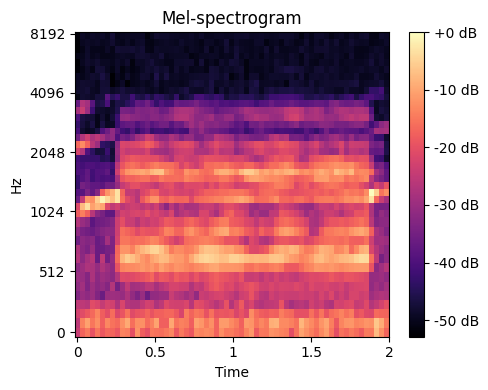

In [ ]:
import librosa.display
import matplotlib.pyplot as plt

# Assuming mel_spec is already computed from the example usage above
# If not, you would need to compute it here first:
# file_path = "/content/drive/MyDrive/clean_fine_tune_data2/siren/1-31482-B-42.wav"
# mel_spec = extract_fixed_length_melspectrogram(file_path)

# Remove the channel dimension before plotting
mel_spec_plot = mel_spec.squeeze()

plt.figure(figsize=(5, 4))
librosa.display.specshow(mel_spec_plot, x_axis='time', y_axis='mel', sr=16000, fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-spectrogram')
plt.tight_layout()
plt.show()

**Batch Processing of Dataset**

In [3]:
import os
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# ----------------------
# CONFIGURATION
# ----------------------
DATASET_PATH = "/content/drive/MyDrive/clean_fine_tune_data2"
EXPECTED_MELS = 40  # Keep same as  function
X = []
y = []

# ----------------------
# LOAD AND PROCESS AUDIO
# ----------------------
print("⏳ Starting Mel-spectrogram extraction...")
for label in os.listdir(DATASET_PATH):
    label_path = os.path.join(DATASET_PATH, label)
    if os.path.isdir(label_path):
        print(f"\n🔍 Processing label: {label}")
        for file in tqdm(os.listdir(label_path)):
            if file.endswith(".wav"):
                file_path = os.path.join(label_path, file)
                try:
                    mel_spec = extract_fixed_length_melspectrogram(file_path, n_mels=EXPECTED_MELS)
                    mel_spec = mel_spec[..., np.newaxis]  # For CNN input: (height, width, channels)
                    X.append(mel_spec)
                    y.append(label)
                except Exception as e:
                    print(f"⚠️ Error processing {file}: {e}")

# ----------------------
# LABEL ENCODING
# ----------------------
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# ----------------------
# CONVERT TO NUMPY
# ----------------------
X = np.array(X, dtype=np.float32)
y = np.array(y_encoded, dtype=np.int32)

# ----------------------
# SAVE DATASETS
# ----------------------
np.save("X_melspectrogram.npy", X)
np.save("y_labels.npy", y)

print(f"\n✅ Finished. Shapes:\nX: {X.shape}\ny: {y.shape}")
print("Classes:", encoder.classes_)


⏳ Starting Mel-spectrogram extraction...

🔍 Processing label: normal


100%|██████████| 7621/7621 [03:09<00:00, 40.15it/s]



🔍 Processing label: glass_break


100%|██████████| 160/160 [00:03<00:00, 43.66it/s] 



🔍 Processing label: help


100%|██████████| 952/952 [00:21<00:00, 44.83it/s] 



🔍 Processing label: scream


100%|██████████| 614/614 [00:15<00:00, 40.23it/s] 



🔍 Processing label: gun_shot


100%|██████████| 1496/1496 [00:36<00:00, 40.66it/s] 



🔍 Processing label: siren


100%|██████████| 3173/3173 [01:16<00:00, 41.46it/s] 



✅ Finished. Shapes:
X: (14016, 40, 63, 1)
y: (14016,)
Classes: ['glass_break' 'gun_shot' 'help' 'normal' 'scream' 'siren']


Loading the saved mel-spectrogram

In [4]:
X = np.load("X_melspectrogram.npy")
y = np.load("y_labels.npy")

print(X.shape, y.shape)  # Should print (14016, 40, 63, 1) and (14016,)


(14016, 40, 63, 1) (14016,)


Splitting the dataset into train/dev/test (70/15/15)

In [5]:
# Emergency if label != normal (i.e., label != 3)
# As per your previous list, 'normal' was index 3
y_binary = np.where(y == 3, 0, 1)


In [6]:
from sklearn.model_selection import train_test_split

#Train/test/dev split (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_binary, test_size=0.3, stratify=y_binary, random_state=42
)

X_dev, X_test, y_dev, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Dev:  ", X_dev.shape, y_dev.shape)
print("Test: ", X_test.shape, y_test.shape)


Train: (9811, 40, 63, 1) (9811,)
Dev:   (2102, 40, 63, 1) (2102,)
Test:  (2103, 40, 63, 1) (2103,)


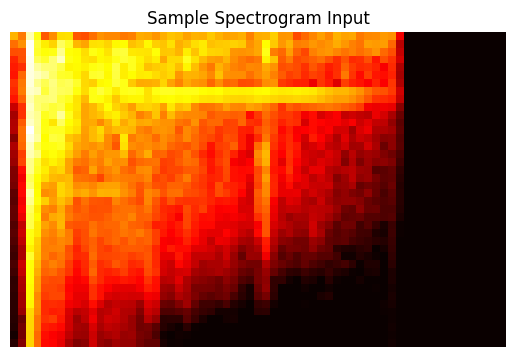

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(X_train[345].squeeze(),cmap= 'hot')
plt.title("Sample Spectrogram Input")
plt.axis('off')
plt.show()

CNN Model

In [7]:
import tensorflow
from tensorflow import keras

In [ ]:
from tensorflow.keras import layers, models

input_shape = (40, 63, 1)  # Based on our spectrogram

model = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid'),  # Binary output
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 40, 63, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 40, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 31, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4480)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       573,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 667,265 (2.55 MB)

 Trainable params: 666,817 (2.54 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose = 1
)

checkpoint = ModelCheckpoint(
    'best_CNN_model.h5',        # File to save best model
    monitor='val_accuracy',     # Metric to monitor
    save_best_only=True,    # Only save when val_accuracy improves
    verbose=1
)


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_dev, y_dev),
    callbacks=[early_stop, checkpoint]
)


Epoch 1/50
306/307 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9789 - loss: 0.0644
Epoch 1: val_accuracy improved from -inf to 0.88059, saving model to best_CNN_model.h5


307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9789 - loss: 0.0644 - val_accuracy: 0.8806 - val_loss: 0.4273
Epoch 2/50
301/307 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9742 - loss: 0.0717
Epoch 2: val_accuracy improved from 0.88059 to 0.93340, saving model to best_CNN_model.h5


307/307 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9742 - loss: 0.0716 - val_accuracy: 0.9334 - val_loss: 0.2625
Epoch 3/50
306/307 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9781 - loss: 0.0591
Epoch 3: val_accuracy improved from 0.93340 to 0.96670, saving model to best_CNN_model.h5


307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9781 - loss: 0.0591 - val_accuracy: 0.9667 - val_loss: 0.1072
Epoch 4/50
297/307 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9823 - loss: 0.0538
Epoch 4: val_accuracy did not improve from 0.96670
307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9822 - loss: 0.0540 - val_accuracy: 0.9657 - val_loss: 0.1100
Epoch 5/50
297/307 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9792 - loss: 0.0533
Epoch 5: val_accuracy did not improve from 0.96670
307/307 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9792 - loss: 0.0535 - val_accuracy: 0.9600 - val_loss: 0.1422
Epoch 6/50
305/307 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9824 - loss: 0.0496
Epoch 6: val_accuracy did not improve from 0.96670
307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9824 - loss: 0.0497 - val_accuracy: 0.9101 - val_loss: 0.6161
Epoch 7/50
304/307 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9758 - loss: 0.0707
Epoch 7: val_accuracy did not impro

307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9806 - loss: 0.0517 - val_accuracy: 0.9719 - val_loss: 0.1153
Epoch 9/50
300/307 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9853 - loss: 0.0475
Epoch 9: val_accuracy did not improve from 0.97193
307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9852 - loss: 0.0475 - val_accuracy: 0.9691 - val_loss: 0.1241
Epoch 10/50
306/307 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9844 - loss: 0.0493
Epoch 10: val_accuracy did not improve from 0.97193
307/307 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9844 - loss: 0.0493 - val_accuracy: 0.9486 - val_loss: 0.1656
Epoch 11/50
306/307 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9819 - loss: 0.0485
Epoch 11: val_accuracy did not improve from 0.97193
307/307 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9819 - loss: 0.0485 - val_accuracy: 0.9719 - val_loss: 0.0996
Epoch 12/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9833 - loss: 0.0469
Epoch 12: val_accuracy did not

In [ ]:
# loading the best model
from tensorflow.keras.models import load_model
model = load_model("best_CNN_model.h5")

In [ ]:
model.evaluate(X_test, y_test)

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9702 - loss: 0.1187


[0.10906627029180527, 0.9728958606719971]

In [ ]:
# Predict probabilities
y_probs = model.predict(X_dev)
# Convert probabilities to binary labels (0 or 1)
y_pred = (y_probs > 0.5).astype("int32")


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(y_dev, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report
report = classification_report(y_dev, y_pred, target_names=["Non-Emergency", "Emergency"])
print("Classification Report:\n", report)


Confusion Matrix:
 [[1125   18]
 [  41  918]]
Classification Report:
                precision    recall  f1-score   support

Non-Emergency       0.96      0.98      0.97      1143
    Emergency       0.98      0.96      0.97       959

     accuracy                           0.97      2102
    macro avg       0.97      0.97      0.97      2102
 weighted avg       0.97      0.97      0.97      2102



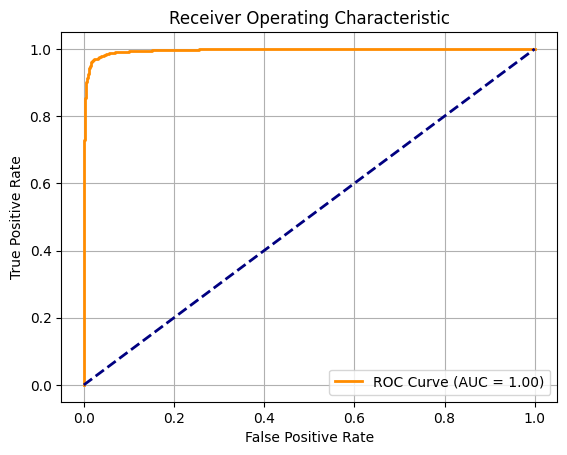

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_dev, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()


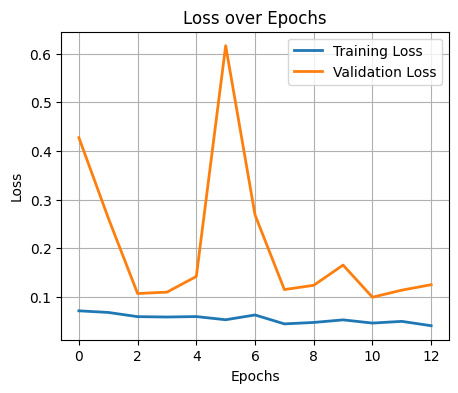

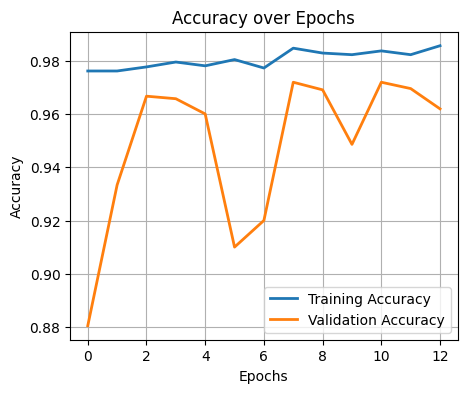

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(5, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


The above CNN model is showing Overfiiting, so we will try other approaches

**Simpler CNN**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.2, stratify=y_binary, random_state=42
)

In [ ]:
from tensorflow.keras import layers, models
input_shape = (40, 63, 1)  # Based on our spectrogram

model = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 40, 63, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 40, 63, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 31, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 31, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2240)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       143,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,233 (653.25 KB)

 Trainable params: 167,009 (652.38 KB)

 Non-trainable params: 224 (896.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose = 1
)

checkpoint = ModelCheckpoint(
    'best_CNN_model2.h5',        # File to save best model
    monitor='val_accuracy',     # Metric to monitor
    save_best_only=True,    # Only save when val_accuracy improves
    verbose=1
)


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint]
)

Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9552 - loss: 0.1181
Epoch 1: val_accuracy did not improve from 0.96242
351/351 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9552 - loss: 0.1181 - val_accuracy: 0.9593 - val_loss: 0.1046
Epoch 2/50
347/351 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9573 - loss: 0.1155
Epoch 2: val_accuracy improved from 0.96242 to 0.97004, saving model to best_CNN_model3.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9573 - loss: 0.1155 - val_accuracy: 0.9700 - val_loss: 0.0807
Epoch 3/50
349/351 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9642 - loss: 0.1044
Epoch 3: val_accuracy did not improve from 0.97004
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9642 - loss: 0.1044 - val_accuracy: 0.9679 - val_loss: 0.0851
Epoch 4/50
343/351 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9646 - loss: 0.1061
Epoch 4: val_accuracy did not improve from 0.97004
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9645 - loss: 0.1063 - val_accuracy: 0.9683 - val_loss: 0.0870
Epoch 5/50
341/351 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9602 - loss: 0.1045
Epoch 5: val_accuracy did not improve from 0.97004
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9601 - loss: 0.1047 - val_accuracy: 0.9668 - val_loss: 0.0898
Epoch 6/50
342/351 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9617 - loss: 0.1068
Epoch 6: val_accuracy did not impro

In [ ]:
# Predict probabilities
y_probs = model.predict(X_test)
# Convert probabilities to binary labels (0 or 1)
y_pred = (y_probs > 0.5).astype("int32")


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report
report = classification_report(y_test, y_pred, target_names=["Non-Emergency", "Emergency"])
print("Classification Report:\n", report)


Confusion Matrix:
 [[1482   43]
 [  41 1238]]
Classification Report:
                precision    recall  f1-score   support

Non-Emergency       0.97      0.97      0.97      1525
    Emergency       0.97      0.97      0.97      1279

     accuracy                           0.97      2804
    macro avg       0.97      0.97      0.97      2804
 weighted avg       0.97      0.97      0.97      2804



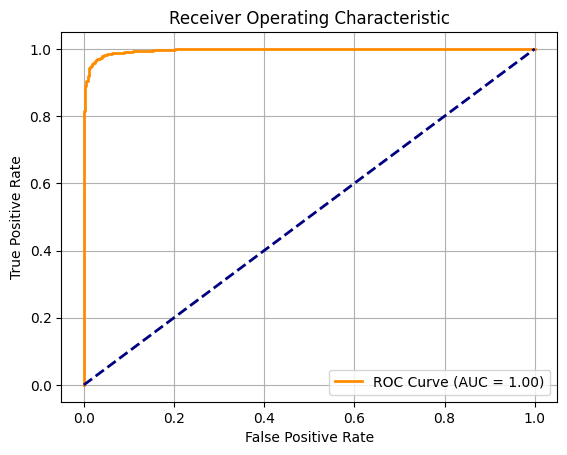

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()


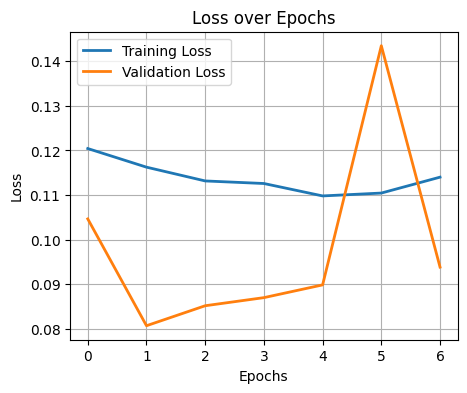

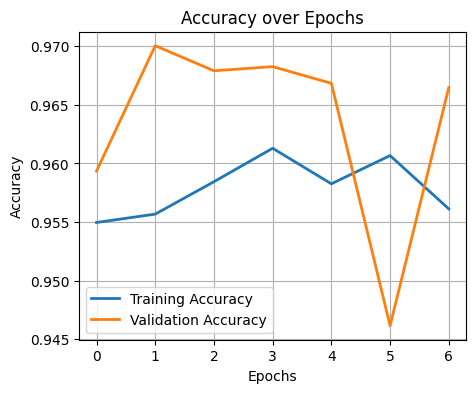

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(5, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


CNN with BatchNormalization before activation function

In [ ]:
model = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(16, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(64),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(1, activation='sigmoid')  # Binary output
])


In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose = 1
)

checkpoint = ModelCheckpoint(
    'best_CNN_model3.h5',        # File to save best model
    monitor='val_accuracy',     # Metric to monitor
    save_best_only=True,    # Only save when val_accuracy improves
    verbose=1
)


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint]
)

Epoch 1/50
341/351 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9576 - loss: 0.1167
Epoch 1: val_accuracy did not improve from 0.97004
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9576 - loss: 0.1167 - val_accuracy: 0.9586 - val_loss: 0.1118
Epoch 2/50
341/351 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9593 - loss: 0.1114
Epoch 2: val_accuracy did not improve from 0.97004
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9592 - loss: 0.1115 - val_accuracy: 0.9426 - val_loss: 0.1518
Epoch 3/50
349/351 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9570 - loss: 0.1136
Epoch 3: val_accuracy did not improve from 0.97004
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9570 - loss: 0.1136 - val_accuracy: 0.9647 - val_loss: 0.0927
Epoch 4/50
347/351 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9597 - loss: 0.1083
Epoch 4: val_accuracy did not improve from 0.97004
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9597 - loss: 0.1082 - val_accuracy: 0.9583 - v

351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9612 - loss: 0.1015 - val_accuracy: 0.9718 - val_loss: 0.0709
Epoch 12/50
346/351 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9702 - loss: 0.0836
Epoch 12: val_accuracy did not improve from 0.97183
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9701 - loss: 0.0837 - val_accuracy: 0.9665 - val_loss: 0.0879
Epoch 13/50
343/351 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9667 - loss: 0.0888
Epoch 13: val_accuracy did not improve from 0.97183
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9666 - loss: 0.0889 - val_accuracy: 0.9711 - val_loss: 0.0743
Epoch 14/50
347/351 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9667 - loss: 0.0900
Epoch 14: val_accuracy did not improve from 0.97183
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9666 - loss: 0.0901 - val_accuracy: 0.9704 - val_loss: 0.0826
Epoch 15/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9662 - loss: 0.0955
Epoch 15: val_accuracy did n

351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9625 - loss: 0.0987 - val_accuracy: 0.9725 - val_loss: 0.0707
Epoch 17/50
346/351 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9631 - loss: 0.0956
Epoch 17: val_accuracy did not improve from 0.97254
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9631 - loss: 0.0956 - val_accuracy: 0.9708 - val_loss: 0.0787
Epoch 18/50
344/351 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9671 - loss: 0.0874
Epoch 18: val_accuracy improved from 0.97254 to 0.97432, saving model to best_CNN_model3.h5


351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9671 - loss: 0.0874 - val_accuracy: 0.9743 - val_loss: 0.0650
Epoch 19/50
347/351 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9707 - loss: 0.0850
Epoch 19: val_accuracy did not improve from 0.97432
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9707 - loss: 0.0850 - val_accuracy: 0.9722 - val_loss: 0.0773
Epoch 20/50
341/351 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9629 - loss: 0.1011
Epoch 20: val_accuracy did not improve from 0.97432
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9629 - loss: 0.1009 - val_accuracy: 0.9736 - val_loss: 0.0735
Epoch 21/50
348/351 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9699 - loss: 0.0872
Epoch 21: val_accuracy did not improve from 0.97432
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9699 - loss: 0.0872 - val_accuracy: 0.9736 - val_loss: 0.0654
Epoch 22/50
338/351 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9700 - loss: 0.0823
Epoch 22: val_accuracy did n

In [ ]:
# Predict probabilities
y_probs = model.predict(X_test)
# Convert probabilities to binary labels (0 or 1)
y_pred = (y_probs > 0.5).astype("int32")


88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report
report = classification_report(y_test, y_pred, target_names=["Non-Emergency", "Emergency"])
print("Classification Report:\n", report)


Confusion Matrix:
 [[1478   47]
 [  25 1254]]
Classification Report:
                precision    recall  f1-score   support

Non-Emergency       0.98      0.97      0.98      1525
    Emergency       0.96      0.98      0.97      1279

     accuracy                           0.97      2804
    macro avg       0.97      0.97      0.97      2804
 weighted avg       0.97      0.97      0.97      2804



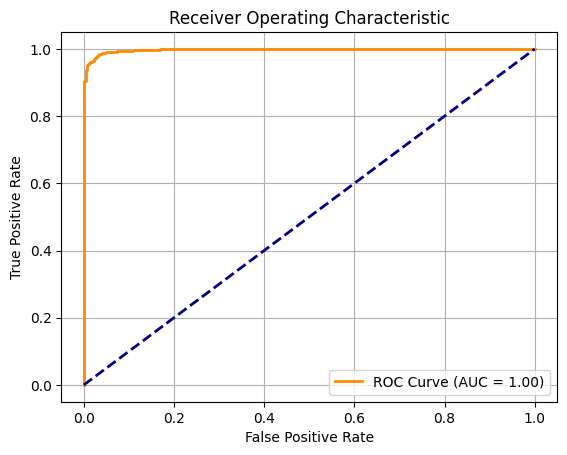

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()


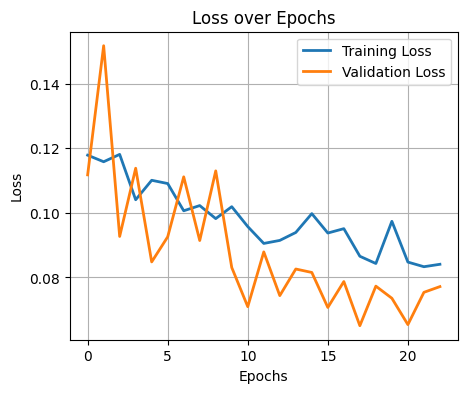

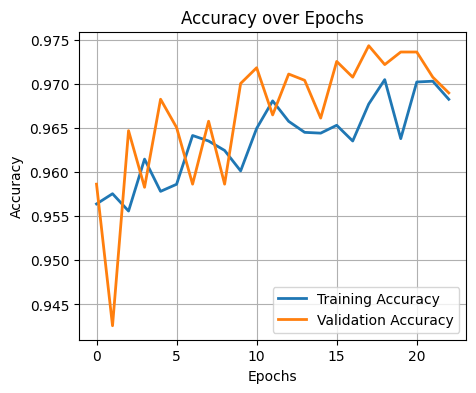

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(5, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define augmentation for spectrograms
datagen = ImageDataGenerator(
    width_shift_range=0.15,      # Time shift
    height_shift_range=0.1,      # Frequency shift
    zoom_range=0.1,
    brightness_range=[0.8, 1.2], # Simulate varying loudness
    fill_mode='nearest'
)

# Create generator
train_generator = datagen.flow(X_train, y_train, batch_size=32, shuffle=True)


In [ ]:
from tensorflow.keras import layers, models
input_shape = (40, 63, 1)  # Based on our spectrogram

model = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(16, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(64),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(1, activation='sigmoid')  # Binary output
])


In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics= ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose = 1
)

checkpoint = ModelCheckpoint(
    'best_CNN_model4.h5',        # File to save best model
    monitor='val_accuracy',     # Metric to monitor
    save_best_only=True,    # Only save when val_accuracy improves
    verbose=1
)

In [ ]:
# Then fit using .fit()
model.fit(train_generator, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stop, checkpoint])


Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.6402 - loss: 0.6935
Epoch 1: val_accuracy improved from -inf to 0.75250, saving model to best_CNN_model4.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 53s 276ms/step - accuracy: 0.6403 - loss: 0.6932 - val_accuracy: 0.7525 - val_loss: 0.5020
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.7160 - loss: 0.5739
Epoch 2: val_accuracy did not improve from 0.75250
176/176 ━━━━━━━━━━━━━━━━━━━━ 46s 263ms/step - accuracy: 0.7161 - loss: 0.5738 - val_accuracy: 0.7507 - val_loss: 0.5177
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.7491 - loss: 0.5184
Epoch 3: val_accuracy did not improve from 0.75250
176/176 ━━━━━━━━━━━━━━━━━━━━ 49s 278ms/step - accuracy: 0.7492 - loss: 0.5183 - val_accuracy: 0.7286 - val_loss: 0.5887
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.7785 - loss: 0.4704
Epoch 4: val_accuracy improved from 0.75250 to 0.77746, saving model to best_CNN_model4.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 255ms/step - accuracy: 0.7785 - loss: 0.4704 - val_accuracy: 0.7775 - val_loss: 0.4835
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.7949 - loss: 0.4450
Epoch 5: val_accuracy did not improve from 0.77746
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 253ms/step - accuracy: 0.7949 - loss: 0.4449 - val_accuracy: 0.7265 - val_loss: 0.6744
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.8145 - loss: 0.4178
Epoch 6: val_accuracy did not improve from 0.77746
176/176 ━━━━━━━━━━━━━━━━━━━━ 85s 270ms/step - accuracy: 0.8145 - loss: 0.4178 - val_accuracy: 0.7393 - val_loss: 0.6100
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.8198 - loss: 0.4007
Epoch 7: val_accuracy did not improve from 0.77746
176/176 ━━━━━━━━━━━━━━━━━━━━ 45s 258ms/step - accuracy: 0.8198 - loss: 0.4007 - val_accuracy: 0.7546 - val_loss: 0.5917
Epoch 8/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.8187 - loss: 0.3942
Epoch 8: val_ac

176/176 ━━━━━━━━━━━━━━━━━━━━ 43s 246ms/step - accuracy: 0.8187 - loss: 0.3942 - val_accuracy: 0.7910 - val_loss: 0.4892
Epoch 9/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.8315 - loss: 0.3811
Epoch 9: val_accuracy did not improve from 0.79101
176/176 ━━━━━━━━━━━━━━━━━━━━ 44s 251ms/step - accuracy: 0.8315 - loss: 0.3810 - val_accuracy: 0.7200 - val_loss: 0.7384
Epoch 10/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.8455 - loss: 0.3597
Epoch 10: val_accuracy did not improve from 0.79101
176/176 ━━━━━━━━━━━━━━━━━━━━ 43s 245ms/step - accuracy: 0.8455 - loss: 0.3597 - val_accuracy: 0.7543 - val_loss: 0.6207
Epoch 11/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.8419 - loss: 0.3598
Epoch 11: val_accuracy did not improve from 0.79101
176/176 ━━━━━━━━━━━━━━━━━━━━ 44s 248ms/step - accuracy: 0.8420 - loss: 0.3597 - val_accuracy: 0.6790 - val_loss: 1.0627
Epoch 12/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.8599 - loss: 0.3385
Epoch 12: 

176/176 ━━━━━━━━━━━━━━━━━━━━ 44s 253ms/step - accuracy: 0.8503 - loss: 0.3470 - val_accuracy: 0.7935 - val_loss: 0.5315
Epoch 14/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.8581 - loss: 0.3268
Epoch 14: val_accuracy improved from 0.79351 to 0.90585, saving model to best_CNN_model4.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 44s 248ms/step - accuracy: 0.8581 - loss: 0.3268 - val_accuracy: 0.9058 - val_loss: 0.2375
Epoch 15/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8653 - loss: 0.3261
Epoch 15: val_accuracy did not improve from 0.90585
176/176 ━━━━━━━━━━━━━━━━━━━━ 44s 253ms/step - accuracy: 0.8653 - loss: 0.3260 - val_accuracy: 0.8299 - val_loss: 0.4153
Epoch 16/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.8666 - loss: 0.3243
Epoch 16: val_accuracy did not improve from 0.90585
176/176 ━━━━━━━━━━━━━━━━━━━━ 44s 252ms/step - accuracy: 0.8666 - loss: 0.3243 - val_accuracy: 0.8128 - val_loss: 0.4921
Epoch 17/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.8731 - loss: 0.2951
Epoch 17: val_accuracy did not improve from 0.90585
176/176 ━━━━━━━━━━━━━━━━━━━━ 44s 250ms/step - accuracy: 0.8731 - loss: 0.2951 - val_accuracy: 0.8545 - val_loss: 0.3307
Epoch 18/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.8765 - loss: 0.2995
Epoch 18

In [ ]:
# Predict probabilities
y_probs = model.predict(X_test)
# Convert probabilities to binary labels (0 or 1)
y_pred = (y_probs > 0.5).astype("int32")


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report
report = classification_report(y_test, y_pred, target_names=["Non-Emergency", "Emergency"])
print("Classification Report:\n", report)


Confusion Matrix:
 [[1428   97]
 [ 167 1112]]
Classification Report:
                precision    recall  f1-score   support

Non-Emergency       0.90      0.94      0.92      1525
    Emergency       0.92      0.87      0.89      1279

     accuracy                           0.91      2804
    macro avg       0.91      0.90      0.90      2804
 weighted avg       0.91      0.91      0.91      2804



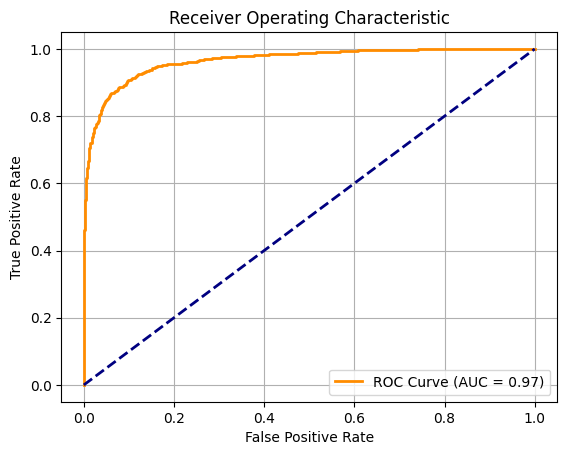

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

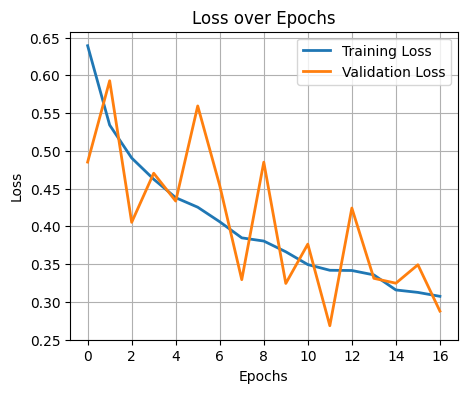

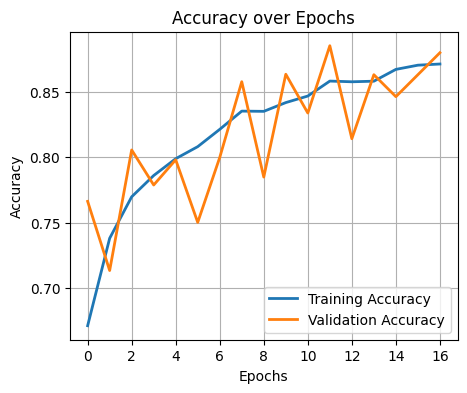

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(5, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Increasing the Batch-size for smoother loss and accuracy curves

In [ ]:
from tensorflow.keras import layers, models
input_shape = (40, 63, 1)  # Based on our spectrogram

model1 = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(16, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(64),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(1, activation='sigmoid')  # Binary output
])


In [ ]:
model1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
train_generator = datagen.flow(X_train, y_train, batch_size=64, shuffle=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose = 1
)

checkpoint = ModelCheckpoint(
    'best_CNN_model3.h5',        # File to save best model
    monitor='val_accuracy',     # Metric to monitor
    save_best_only=True,    # Only save when val_accuracy improves
    verbose=1
)

In [ ]:
history = model1.fit(train_generator, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stop, checkpoint])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.6321 - loss: 0.6928
Epoch 1: val_accuracy improved from -inf to 0.76641, saving model to best_CNN_model3.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 48s 249ms/step - accuracy: 0.6323 - loss: 0.6925 - val_accuracy: 0.7664 - val_loss: 0.4850
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.7234 - loss: 0.5516
Epoch 2: val_accuracy did not improve from 0.76641
176/176 ━━━━━━━━━━━━━━━━━━━━ 83s 254ms/step - accuracy: 0.7234 - loss: 0.5515 - val_accuracy: 0.7136 - val_loss: 0.5928
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.7679 - loss: 0.4978
Epoch 3: val_accuracy improved from 0.76641 to 0.80563, saving model to best_CNN_model3.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 50s 285ms/step - accuracy: 0.7679 - loss: 0.4978 - val_accuracy: 0.8056 - val_loss: 0.4053
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.7896 - loss: 0.4635
Epoch 4: val_accuracy did not improve from 0.80563
176/176 ━━━━━━━━━━━━━━━━━━━━ 75s 246ms/step - accuracy: 0.7895 - loss: 0.4635 - val_accuracy: 0.7789 - val_loss: 0.4703
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.7965 - loss: 0.4363
Epoch 5: val_accuracy did not improve from 0.80563
176/176 ━━━━━━━━━━━━━━━━━━━━ 44s 247ms/step - accuracy: 0.7965 - loss: 0.4364 - val_accuracy: 0.7981 - val_loss: 0.4334
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.8013 - loss: 0.4350
Epoch 6: val_accuracy did not improve from 0.80563
176/176 ━━━━━━━━━━━━━━━━━━━━ 44s 251ms/step - accuracy: 0.8014 - loss: 0.4350 - val_accuracy: 0.7504 - val_loss: 0.5594
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.8169 - loss: 0.4116
Epoch 7: val_ac

176/176 ━━━━━━━━━━━━━━━━━━━━ 46s 263ms/step - accuracy: 0.8411 - loss: 0.3804 - val_accuracy: 0.8577 - val_loss: 0.3294
Epoch 9/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.8387 - loss: 0.3719
Epoch 9: val_accuracy did not improve from 0.85770
176/176 ━━━━━━━━━━━━━━━━━━━━ 44s 251ms/step - accuracy: 0.8386 - loss: 0.3719 - val_accuracy: 0.7850 - val_loss: 0.4849
Epoch 10/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8383 - loss: 0.3610
Epoch 10: val_accuracy improved from 0.85770 to 0.86341, saving model to best_CNN_model3.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 44s 250ms/step - accuracy: 0.8383 - loss: 0.3610 - val_accuracy: 0.8634 - val_loss: 0.3244
Epoch 11/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.8455 - loss: 0.3528
Epoch 11: val_accuracy did not improve from 0.86341
176/176 ━━━━━━━━━━━━━━━━━━━━ 81s 245ms/step - accuracy: 0.8455 - loss: 0.3527 - val_accuracy: 0.8338 - val_loss: 0.3764
Epoch 12/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.8532 - loss: 0.3519
Epoch 12: val_accuracy improved from 0.86341 to 0.88516, saving model to best_CNN_model3.h5


176/176 ━━━━━━━━━━━━━━━━━━━━ 84s 260ms/step - accuracy: 0.8532 - loss: 0.3519 - val_accuracy: 0.8852 - val_loss: 0.2684
Epoch 13/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8633 - loss: 0.3311
Epoch 13: val_accuracy did not improve from 0.88516
176/176 ━━━━━━━━━━━━━━━━━━━━ 44s 252ms/step - accuracy: 0.8633 - loss: 0.3312 - val_accuracy: 0.8142 - val_loss: 0.4242
Epoch 14/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.8537 - loss: 0.3399
Epoch 14: val_accuracy did not improve from 0.88516
176/176 ━━━━━━━━━━━━━━━━━━━━ 49s 279ms/step - accuracy: 0.8537 - loss: 0.3399 - val_accuracy: 0.8631 - val_loss: 0.3311
Epoch 15/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8684 - loss: 0.3113
Epoch 15: val_accuracy did not improve from 0.88516
176/176 ━━━━━━━━━━━━━━━━━━━━ 77s 250ms/step - accuracy: 0.8684 - loss: 0.3113 - val_accuracy: 0.8463 - val_loss: 0.3247
Epoch 16/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.8677 - loss: 0.3196
Epoch 16

In [ ]:
# Predict probabilities
y_probs = model1.predict(X_test)
# Convert probabilities to binary labels (0 or 1)
y_pred = (y_probs > 0.5).astype("int32")


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report
report = classification_report(y_test, y_pred, target_names=["Non-Emergency", "Emergency"])
print("Classification Report:\n", report)


Confusion Matrix:
 [[1446   79]
 [ 243 1036]]
Classification Report:
                precision    recall  f1-score   support

Non-Emergency       0.86      0.95      0.90      1525
    Emergency       0.93      0.81      0.87      1279

     accuracy                           0.89      2804
    macro avg       0.89      0.88      0.88      2804
 weighted avg       0.89      0.89      0.88      2804



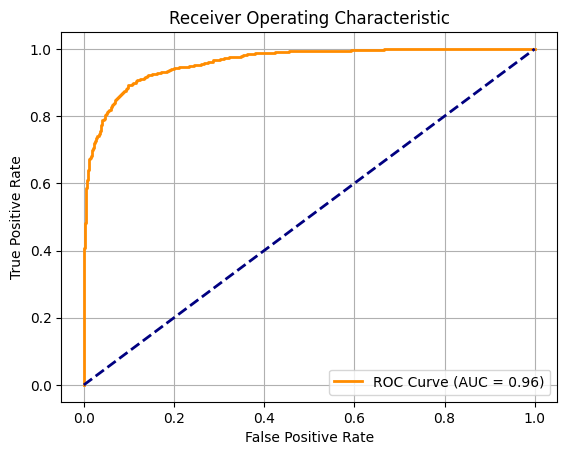

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

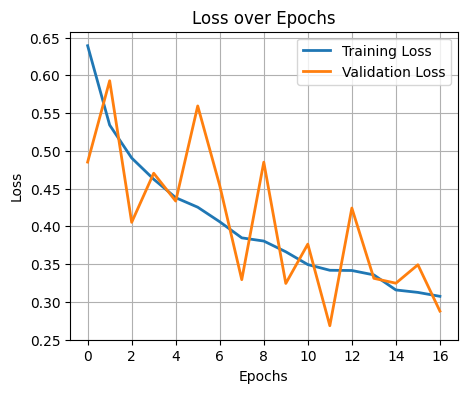

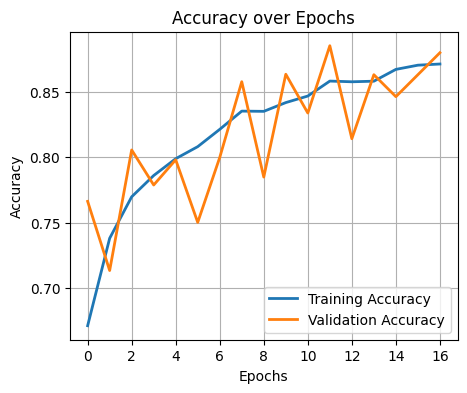

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(5, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Decreasing Dropout from 0.4 to 0.3 in last convolutional layer and flatten layer

In [ ]:
from tensorflow.keras import layers, models
input_shape = (40, 63, 1)

model2 = models.Sequential([
    layers.Input(shape = input_shape),
    layers.Conv2D(16, (3, 3), padding = 'same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(32, (3, 3), padding = 'same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), padding = 'same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(64),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.3),

    layers.Dense(1, activation='sigmoid')  # Binary output
])

In [ ]:
model2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
train_generator = datagen.flow(X_train, y_train, batch_size=32, shuffle=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose = 1
)

checkpoint = ModelCheckpoint(
    'best_CNN_model4.h5',        # File to save best model
    monitor='val_accuracy',     # Metric to monitor
    save_best_only=True,    # Only save when val_accuracy improves
    verbose=1
)

In [ ]:
history = model2.fit(train_generator, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stop, checkpoint])

Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.6674 - loss: 0.6442
Epoch 1: val_accuracy did not improve from 0.91833
351/351 ━━━━━━━━━━━━━━━━━━━━ 51s 133ms/step - accuracy: 0.6675 - loss: 0.6441 - val_accuracy: 0.5942 - val_loss: 0.7707
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7566 - loss: 0.5160
Epoch 2: val_accuracy did not improve from 0.91833
351/351 ━━━━━━━━━━━━━━━━━━━━ 47s 135ms/step - accuracy: 0.7566 - loss: 0.5160 - val_accuracy: 0.7939 - val_loss: 0.4220
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.7835 - loss: 0.4691
Epoch 3: val_accuracy did not improve from 0.91833
351/351 ━━━━━━━━━━━━━━━━━━━━ 45s 128ms/step - accuracy: 0.7835 - loss: 0.4691 - val_accuracy: 0.7814 - val_loss: 0.4865
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8038 - loss: 0.4319
Epoch 4: val_accuracy did not improve from 0.91833
351/351 ━━━━━━━━━━━━━━━━━━━━ 45s 129ms/step - accuracy: 0.8038 - loss: 0.4319 - val_

In [ ]:
# Predict probabilities
y_probs = model2.predict(X_test)
# Convert probabilities to binary labels (0 or 1)
y_pred = (y_probs > 0.65).astype("int32")


88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report
report = classification_report(y_test, y_pred, target_names=["Non-Emergency", "Emergency"])
print("Classification Report:\n", report)

Confusion Matrix:
 [[1496   29]
 [ 287  992]]
Classification Report:
                precision    recall  f1-score   support

Non-Emergency       0.84      0.98      0.90      1525
    Emergency       0.97      0.78      0.86      1279

     accuracy                           0.89      2804
    macro avg       0.91      0.88      0.88      2804
 weighted avg       0.90      0.89      0.89      2804



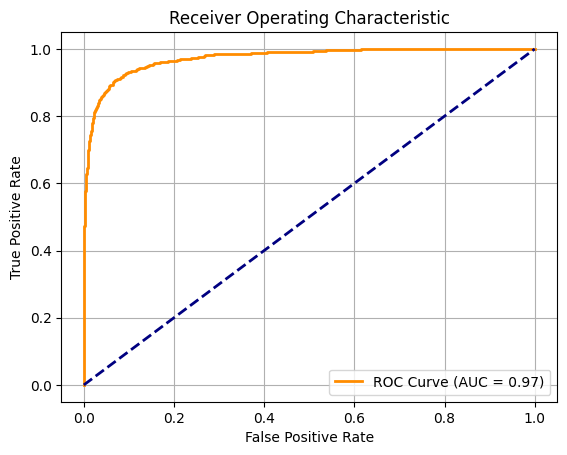

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

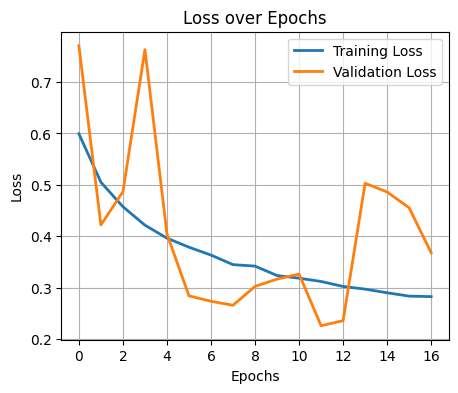

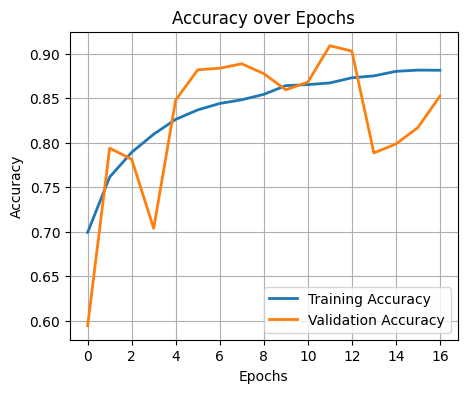

In [ ]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(5, 4))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(5, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Hyperparameter Tuning by using model(1) as base-model**

In [8]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


Define model Builder

In [9]:
import keras_tuner as kt
from tensorflow.keras import layers, models, optimizers

In [14]:
import keras_tuner as kt
from tensorflow.keras import layers, models, optimizers

def build_model(hp):
    model = models.Sequential()

    model.add(layers.Input(shape=(40, 63, 1)))

    # First Conv layer
    model.add(layers.Conv2D(
        filters=hp.Choice('conv1_filters', [32, 64]),
        kernel_size=(3, 3),
        activation='relu',
        padding='same'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(hp.Float('dropout1', 0.2, 0.4, step=0.1)))

    # Second Conv layer
    model.add(layers.Conv2D(
        filters=hp.Choice('conv2_filters', [64, 128]),
        kernel_size=(3, 3),
        activation='relu',
        padding='same'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(hp.Float('dropout2', 0.2, 0.4, step=0.1)))

    # Third Conv layer
    model.add(layers.Conv2D(
        filters=hp.Choice('conv3_filters', [128, 256]),
        kernel_size=(3, 3),
        activation='relu',
        padding='same'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(hp.Float('dropout3', 0.3, 0.5, step=0.1)))

    model.add(layers.Flatten())

    # Dense layer
    model.add(layers.Dense(
        units=hp.Choice('dense_units', [64, 128, 256]),
        activation='relu'
    ))
    model.add(layers.Dropout(hp.Float('dense_dropout', 0.3, 0.5, step=0.1)))

    model.add(layers.Dense(1, activation='sigmoid'))

    # Optimizer and LR
    optimizer_name = hp.Choice('optimizer', ['adam', 'rmsprop'])
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')

    # Get the optimizer class and instantiate it with the learning rate
    optimizer = optimizers.get(optimizer_name).__class__(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

Initialize the Tuner

In [15]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=25,
    executions_per_trial=1,
    directory='hypertuning',
    project_name='audio_cnn'
)


Run the search

In [16]:
tuner.search(X_train, y_train,
             epochs=15,
             validation_data=(X_dev, y_dev),
             batch_size=32,
             callbacks=[keras.callbacks.EarlyStopping(patience=3)])


Trial 25 Complete [00h 00m 59s]
val_accuracy: 0.940057098865509

Best val_accuracy So Far: 0.9552806615829468
Total elapsed time: 00h 20m 42s


Getting best model

In [17]:
best_model = tuner.get_best_models(1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]

print("Best Hyperparameters:")
for key in best_hp.values:
    print(f"{key}: {best_hp.get(key)}")

# Evaluate on test set
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best Hyperparameters:
conv1_filters: 64
dropout1: 0.30000000000000004
conv2_filters: 128
dropout2: 0.2
conv3_filters: 256
dropout3: 0.4
dense_units: 64
dense_dropout: 0.3
optimizer: adam
learning_rate: 0.00012373765890125947
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9589 - loss: 0.1313
Test Accuracy: 0.9610


In [19]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import numpy as np

# Predict probabilities
y_pred_proba = best_model.predict(X_test)

# Convert probabilities to binary predictions using default threshold 0.5
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Confusion Matrix:
 [[1086   57]
 [  25  935]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96      1143
           1       0.94      0.97      0.96       960

    accuracy                           0.96      2103
   macro avg       0.96      0.96      0.96      2103
weighted avg       0.96      0.96      0.96      2103


ROC-AUC Score: 0.9935


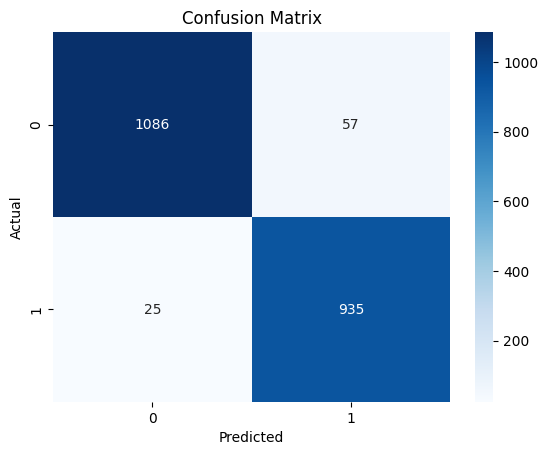

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [21]:
# Get probabilities and convert to binary predictions
y_pred_probs = best_model.predict(X_test).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 


In [22]:
import numpy as np

# Find indices where prediction doesn't match ground truth
misclassified_indices = np.where(y_pred != y_test)[0]


In [25]:
from collections import Counter

# Get list of actual labels of misclassified samples
actual_wrong_labels = y_test[misclassified_indices]
counts = Counter(actual_wrong_labels)

print("Misclassified label counts:", counts)


Misclassified label counts: Counter({np.int64(0): 57, np.int64(1): 25})


In [28]:
best_model.save("best_hp_model.h5")


In [29]:
from tensorflow import lite

converter = lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

with open('best_hp_model.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpg9eymudc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 40, 63, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132045131776272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132045206403792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132045147666384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132045147653328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132045131777040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132045206395728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132045147661584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132045147667536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132045117718160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132045117714512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132045147661776: